In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as f
import torch.utils.data as data
import torch.optim as optim
import numpy as np

from datasets import load_dataset
from src.landscape import Landscape
from src.trainer import Trainer
from src.plot import Plot

/Users/tonimo/git/teaching-networks/venv/lib/python3.12/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


In [ ]:
def pre_process(example):
    arr = np.reshape(example["input"], -1)
    example["input"] = arr
    return example

In [ ]:
mnist = load_dataset("mnist", trust_remote_code=True)
train, test = mnist.get("train"), mnist.get("test")

In [ ]:
train.set_format(type="numpy", columns=["image", "label"])
test.set_format(type="numpy", columns=["image", "label"])
train = train.rename_column("image", "input")
test = test.rename_column("image", "input")
train = train.map(pre_process, num_proc=4)
test = test.map(pre_process, num_proc=4)

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
train_inputs = torch.from_numpy(train["input"]).float().squeeze() / 255.0
test_inputs = torch.from_numpy(test["input"]).float().squeeze() / 255.0
train_labels = torch.from_numpy(train["label"]).long()
test_labels = torch.from_numpy(test["label"]).long()

In [ ]:
train_dataset = data.TensorDataset(train_inputs, train_labels)
test_dataset = data.TensorDataset(test_inputs, test_labels)

In [ ]:
class Model(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.linear_1 = nn.Linear(28 * 28, 512)
        self.drop_1 = nn.Dropout(0.5)
        self.linear_2 = nn.Linear(512, 512)
        self.drop_2 = nn.Dropout(0.25)
        self.linear_3 = nn.Linear(512, 10)

    def forward(self, x):
        x = f.relu(self.drop_1(self.linear_1(x)))
        x = f.relu(self.drop_2(self.linear_2(x)))
        return f.relu(self.linear_3(x))


In [ ]:
model = Model()
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()
batch_size = 256

In [ ]:
train_loader = data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    drop_last=False,
    pin_memory=True,
)

test_loader = data.DataLoader(
    test_dataset,
    batch_size=len(test_dataset),
    shuffle=True,
    drop_last=False,
    pin_memory=True,
)

In [ ]:
trainer = Trainer(model, optimizer, loss_fn, write=True, metric_path="./metrics.h5", param_path="./params.pt", traj_path="./traj.pt")

In [ ]:
metrics, trajectory = trainer.train(train_loader, test_loader, epochs=50, device=device, print_every=10)

In [ ]:
model = Model()
landscape = Landscape.from_files(model, loss_fn, param_path="./params.pt", traj_path="./traj.pt")

In [ ]:
(X, Y, Z), trajectory = landscape.create_landscape(test_loader, mode="pca", print_every=25)

In [2]:
plot = Plot.from_files(mesh_path="./landscape.h5")

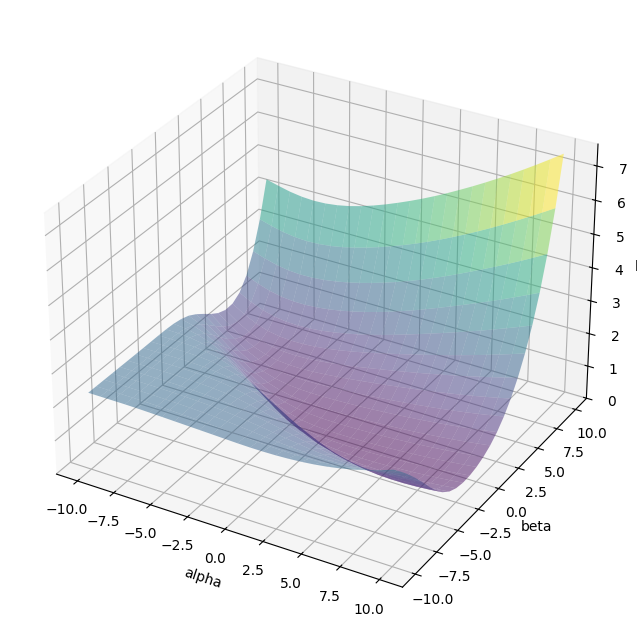

In [3]:
plot.plot_surface_3D(file_path="./loss-landscape.png")

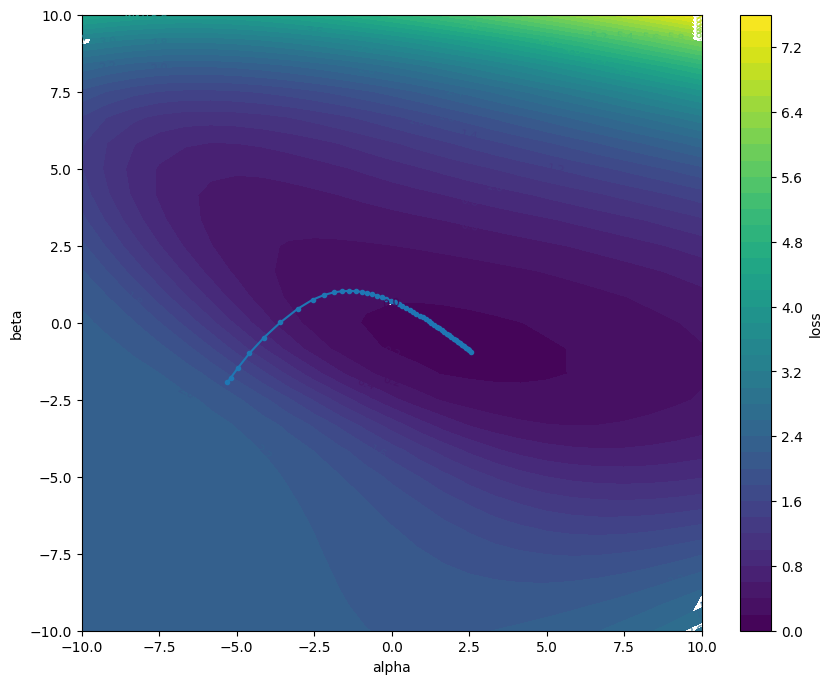

In [4]:
plot.plot_contour(levels=40, plot_trajectory=True, file_path="./loss-contour.png")

In [5]:
plot.animate_contour(levels=40,  file_path="./animated-contour.gif")